## Feature Selection 

In [1]:
from importlib import reload
import pandas as pd
import feature_selection as fs
reload(fs)

e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'feature_selection' from 'e:\\Ames-Housing-Price-Predictor\\notebooks\\feature_selection.py'>

### Load the dataset

In [2]:
df = pd.read_parquet("../data/processed/05_feature_engineering.parquet")

In [3]:
target = 'saleprice'
cat_features = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = fs.category_encoding(df, cat_features, target)

In [4]:
num_features = df_encoded.drop(columns = target).columns.tolist()

### Numerical Features -> Numerical Target

#### Correlation

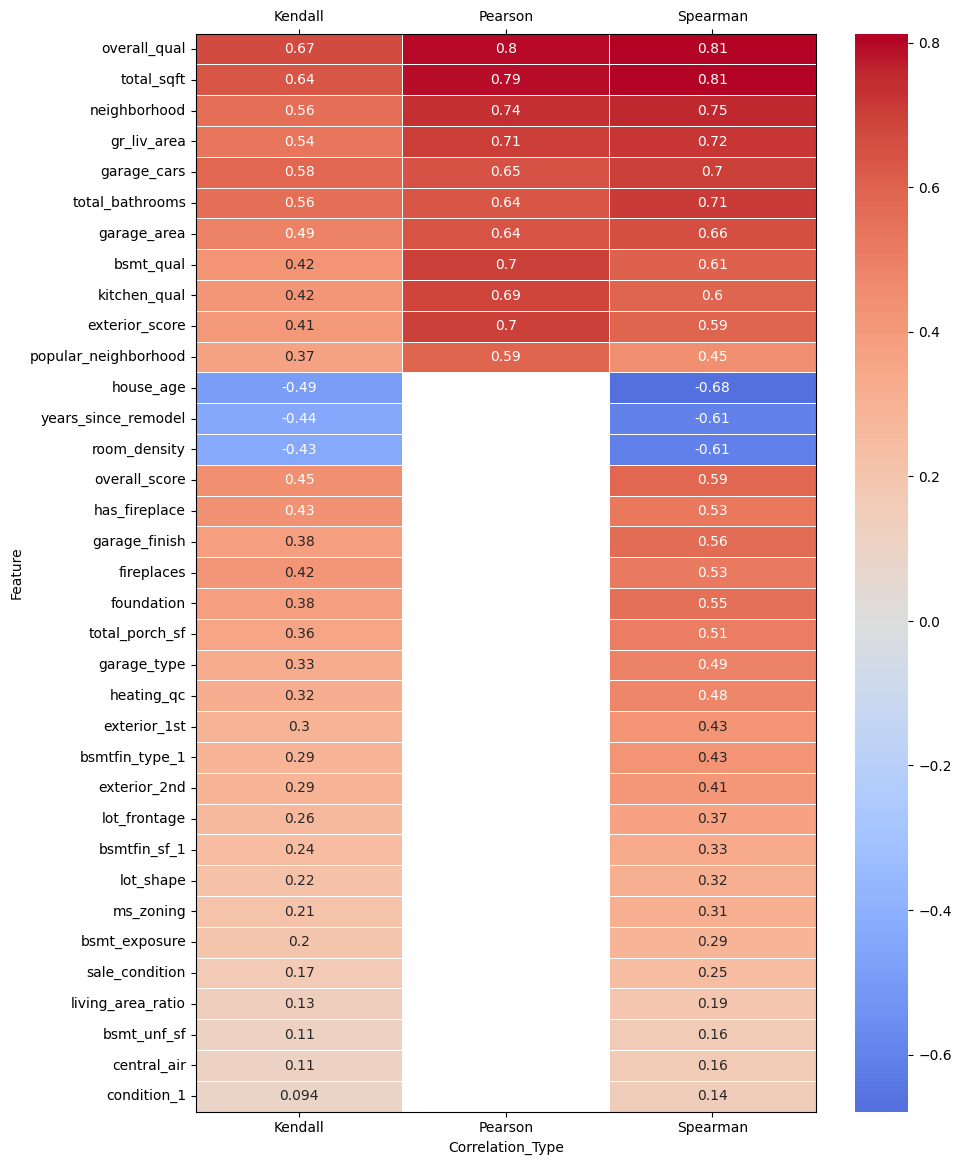

In [5]:
reload(fs)

corr_ranking = fs.correlation(
    df_encoded,
    num_features,
    target,
    soft=False,
    display_images=True,
)

#### Mutual Information Regression

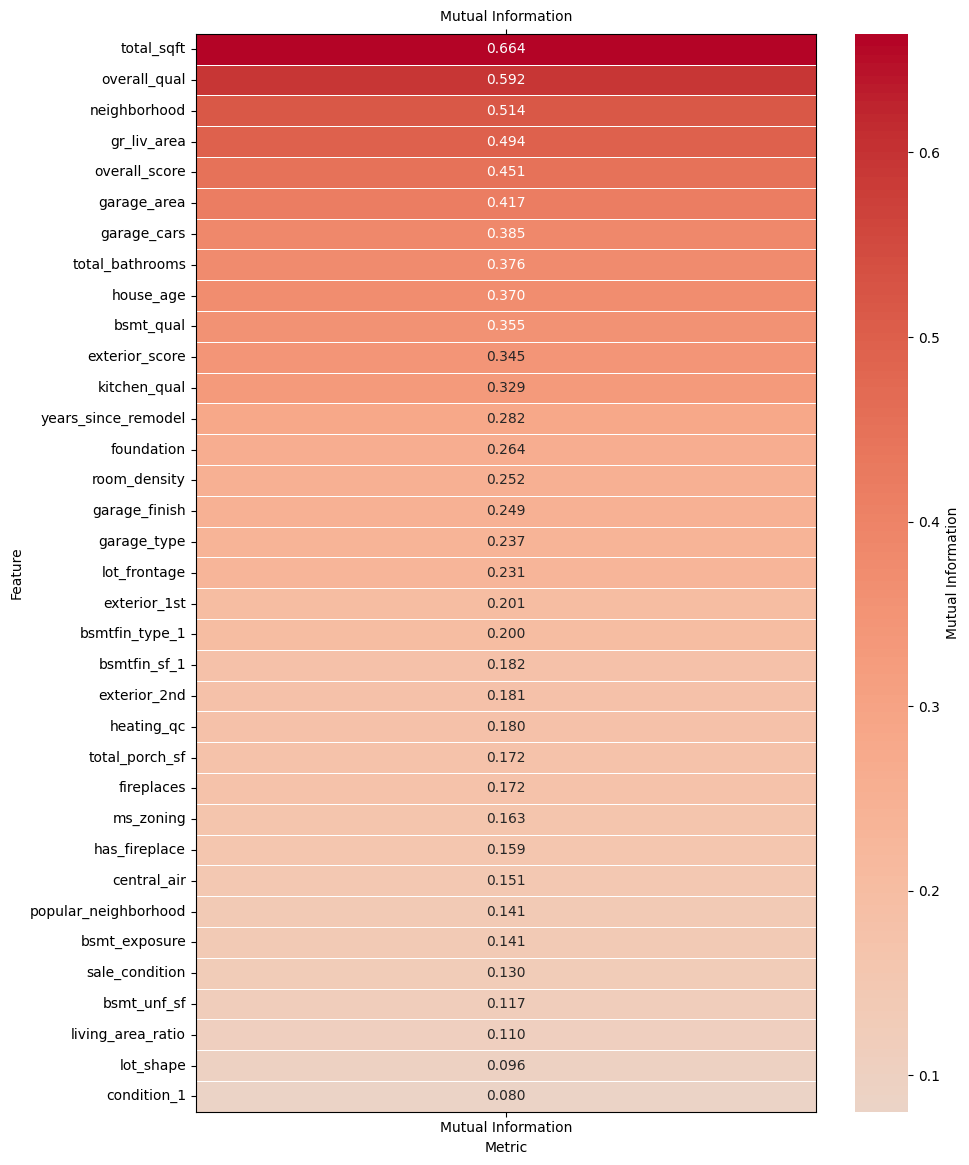

In [6]:
reload(fs)
mi_ranking = fs.mutual_information_reg(df_encoded, num_features, target, display_images=True)

#### Grid-Search for tree models -> Permutation Importance

In [7]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

regression_models = {
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(tree_method="hist", device="cuda"),
    "CatBoost": CatBoostRegressor(task_type="GPU", devices='0', verbose=0),
    "LightGBM": LGBMRegressor(device='gpu', verbose=-1)
}

regression_param_grids = {
    "RandomForest": {
        'n_estimators': [100, 150, 200, 250],
        'max_depth': [10, 20, 25, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
    },
    "XGBoost": {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [1, 1.5, 2]
    },
    "CatBoost": {
        'iterations': [100, 150, 200],
        'depth': [4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'l2_leaf_reg': [1, 3, 5, 7],
        'border_count': [32, 64, 128]
    },
    "LightGBM": {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'num_leaves': [31, 40, 60],
        'max_depth': [-1, 10, 20],
        'min_child_samples': [5, 10, 20],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [0, 0.5, 1]
    }
}

In [8]:
best_models = fs.random_search_regression(
    df_encoded,
    num_features,
    target,
    regression_models,
    regression_param_grids,
)

Training RandomForest...
Best parameters for RandomForest: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 25}
Training XGBoost...


e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [01:50:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Best parameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
Training CatBoost...
Best parameters for CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 150, 'depth': 6, 'border_count': 128}
Training LightGBM...
Best parameters for LightGBM: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'num_leaves': 31, 'n_estimators': 150, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


,rmse,r2,mae
RandomForest,25284.914968,0.920259,15005.997964
XGBoost,21868.837767,0.940350,13822.615628
CatBoost,21751.563278,0.940988,13934.695854
LightGBM,22869.730169,0.934765,13864.216901


### Permutation importance

📂 Fold 1/2 — Modelo: RandomForest
📂 Fold 1/2 — Modelo: XGBoost
📂 Fold 1/2 — Modelo: CatBoost


e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


📂 Fold 1/2 — Modelo: LightGBM


e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


📂 Fold 2/2 — Modelo: RandomForest


e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


📂 Fold 2/2 — Modelo: XGBoost
📂 Fold 2/2 — Modelo: CatBoost
📂 Fold 2/2 — Modelo: LightGBM


e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


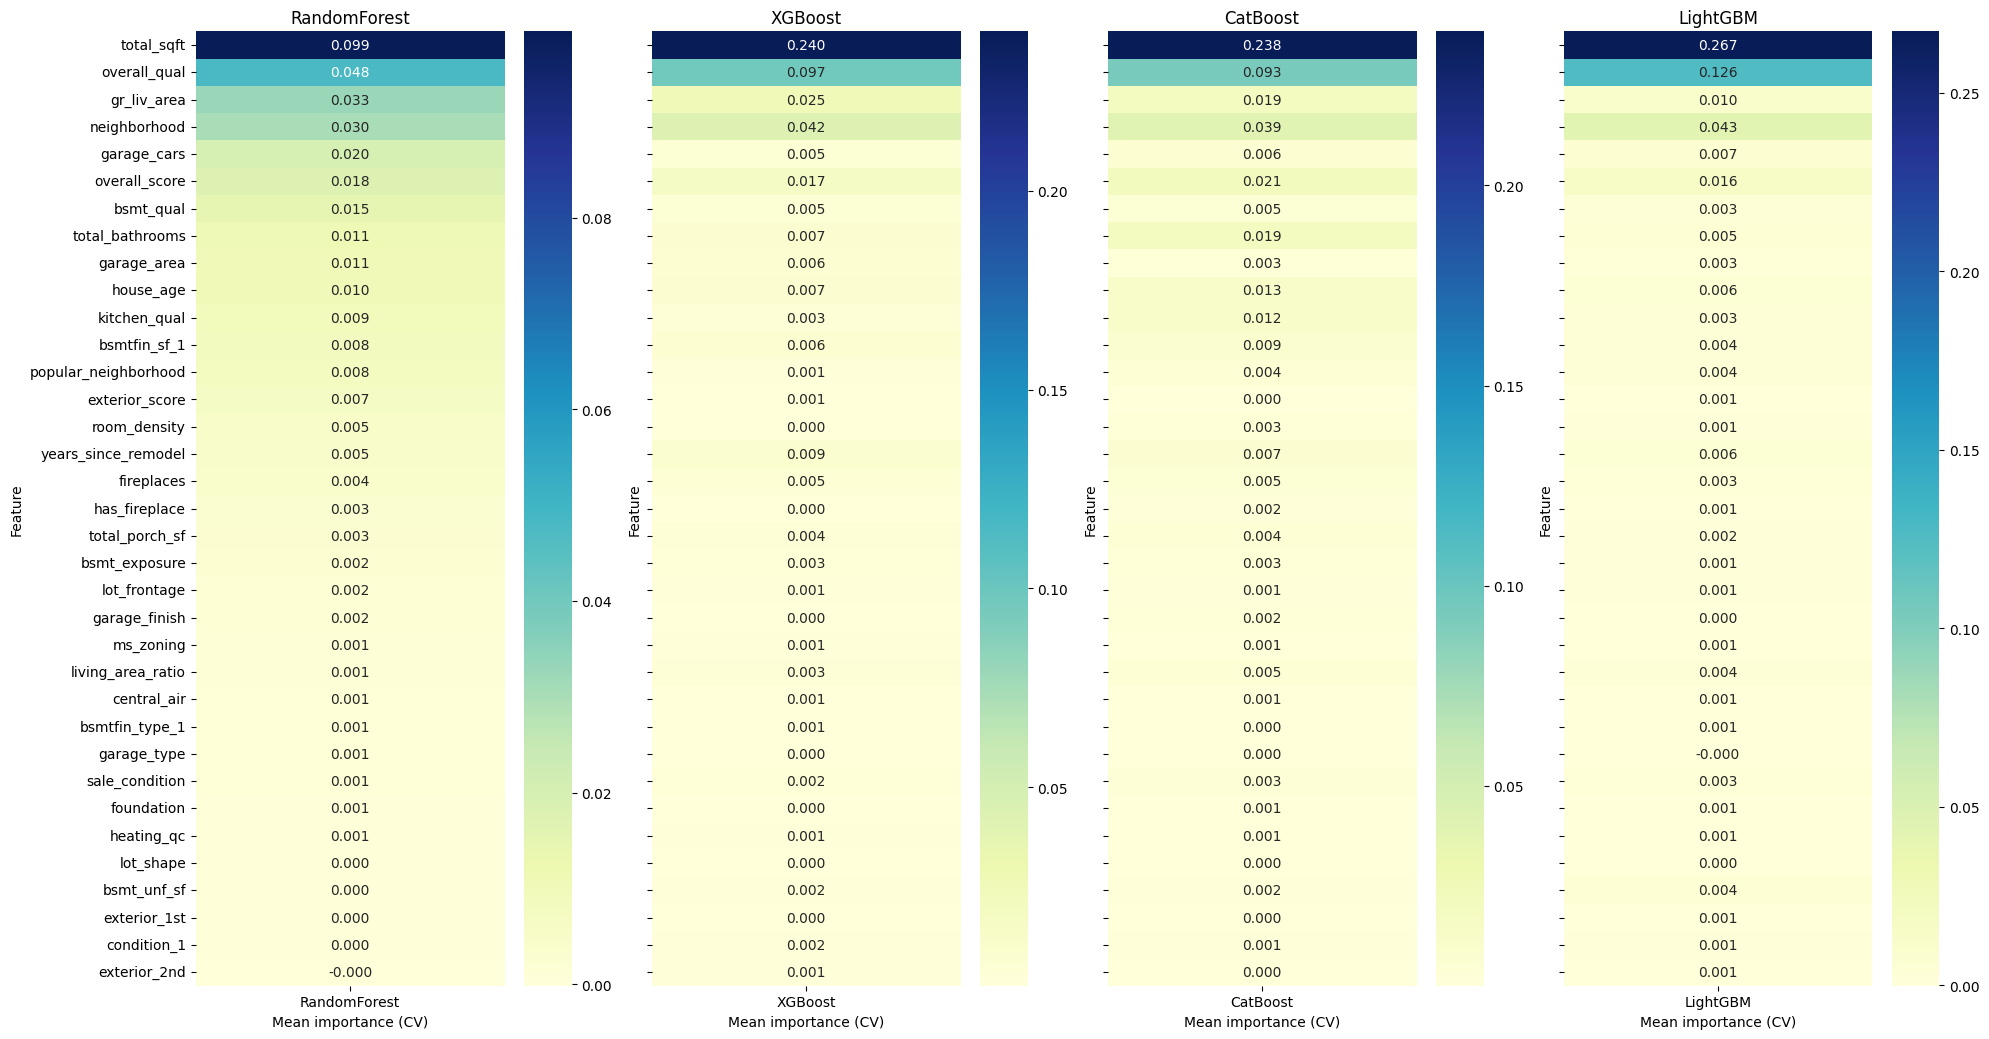

In [9]:
perm_ranking = fs.permutation_importanceCV(
    df_encoded,
    num_features,
    target,
    best_models,
    random_state=42,
    scoring='r2',
    n_splits=2,
    n_repeats=25
)

### Shap Importance

🔍 Entrenando modelo: RandomForest


100%|===================| 299/300 [01:18<00:00]        

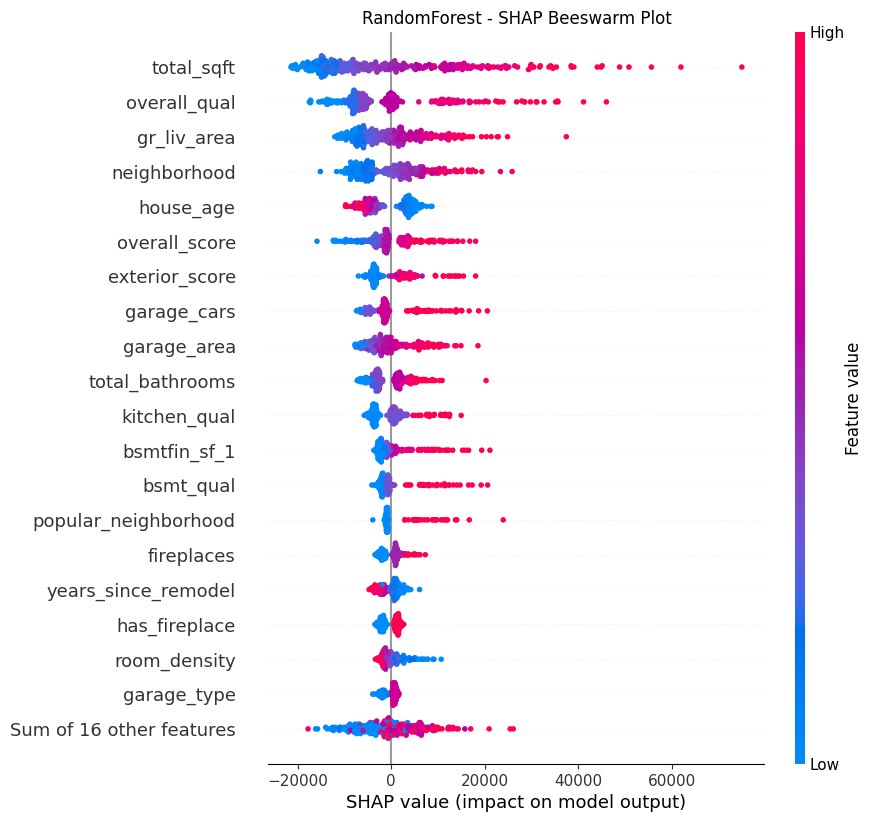

🔍 Entrenando modelo: XGBoost


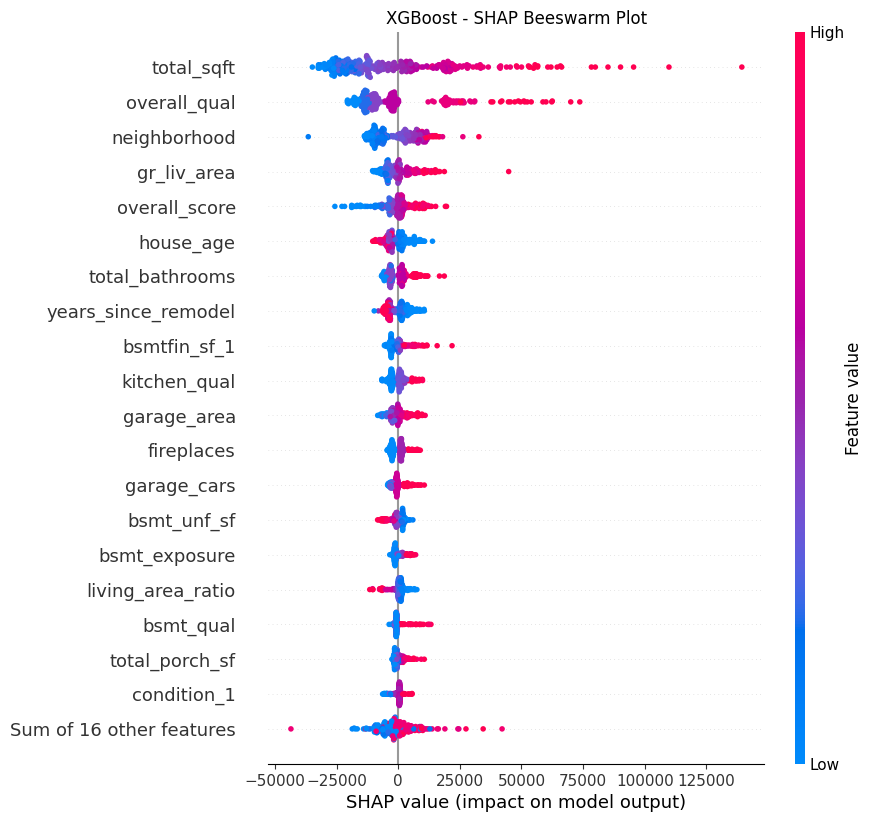

🔍 Entrenando modelo: CatBoost


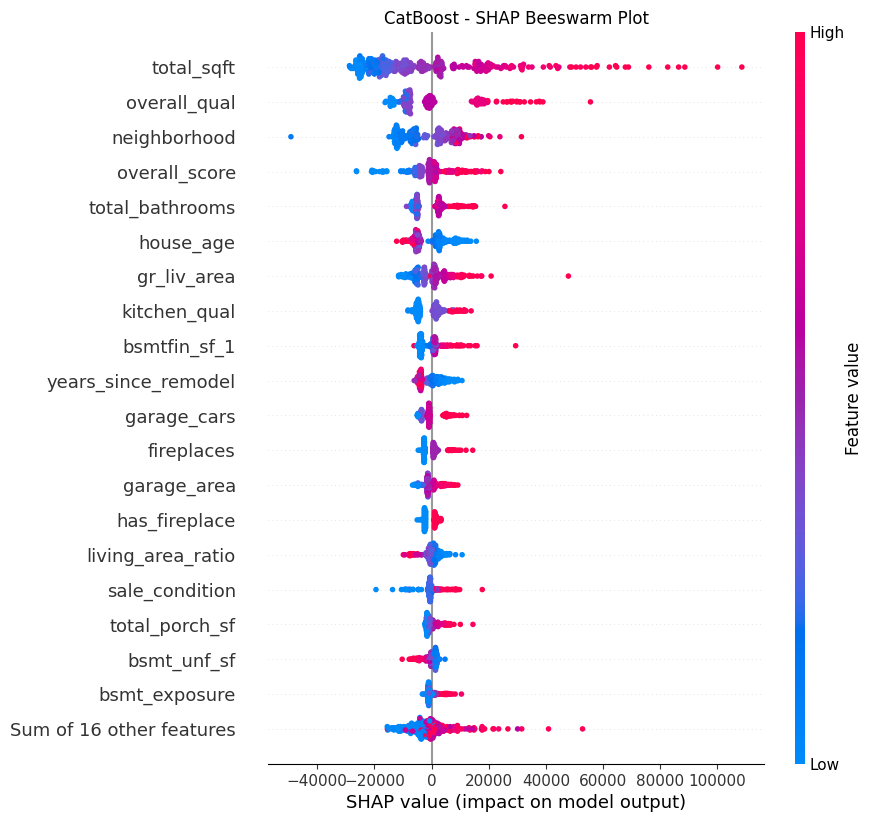

In [10]:
reload(fs)
shap_ranking = fs.shap_importance(
    models={"RandomForest": best_models["RandomForest"],
            "XGBoost": best_models["XGBoost"],
            "CatBoost": best_models["CatBoost"],},
    X=df_encoded[num_features],
    y=df_encoded[target],
    n_sample=300,
    top_n=20,
    random_state=42,
)

### Ranking Conclusion

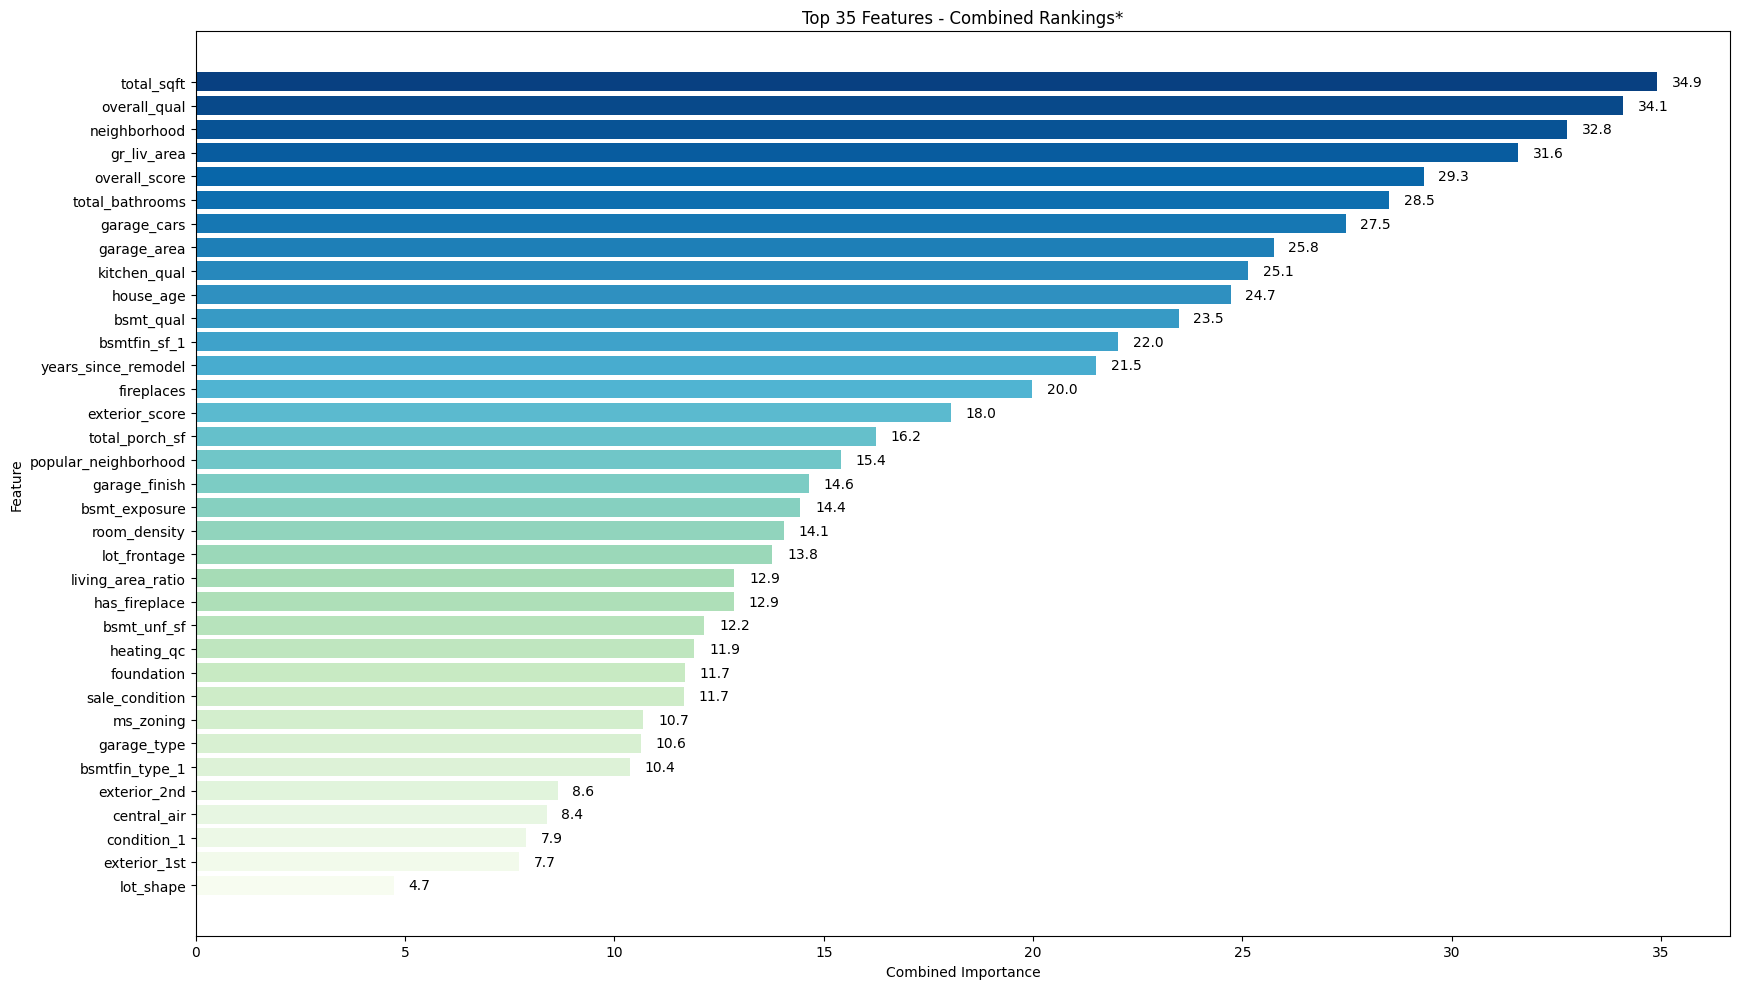

In [11]:
reload(fs)
selected_columns = fs.plot_feature_importance(
    shap_ranking,
    perm_ranking,
    corr_ranking,
    mi_ranking,
    top_n=35
)

In [12]:
df_final = df_encoded[selected_columns + [target]]

In [13]:
df_final.to_parquet(
    "../data/processed/06_feature_selection.parquet",
    index=False,
)

In [17]:
df_final

,total_sqft,overall_qual,neighborhood,gr_liv_area,overall_score,total_bathrooms,garage_cars,garage_area,kitchen_qual,house_age,...,sale_condition,ms_zoning,garage_type,bsmtfin_type_1,exterior_2nd,central_air,condition_1,exterior_1st,lot_shape,saleprice
0,2736.0,6,180796.060068,1656.0,30,2.0,2,528.0,180796.060068,50,...,180796.060068,180796.060068,180796.060068,180796.060068,180796.060068,180796.060068,180796.060068,180796.060068,180796.060068,215000.0
1,1778.0,5,197898.030034,896.0,30,1.0,1,730.0,197898.030034,49,...,197898.030034,180796.060068,197898.030034,180796.060068,180796.060068,197898.030034,180796.060068,180796.060068,180796.060068,105000.0
2,2658.0,6,166932.020023,1329.0,36,1.5,1,312.0,180796.060068,52,...,166932.020023,197898.030034,166932.020023,180796.060068,180796.060068,166932.020023,197898.030034,180796.060068,197898.030034,172000.0
3,4220.0,7,168199.015017,2110.0,35,3.5,2,522.0,180796.060068,42,...,168199.015017,189265.353356,168199.015017,176398.030034,180796.060068,168199.015017,189265.353356,197898.030034,142898.030034,244000.0
4,2557.0,5,180796.060068,1629.0,25,2.5,2,482.0,166932.020023,13,...,183359.212014,202949.015017,183359.212014,180796.060068,142898.030034,183359.212014,202949.015017,142898.030034,189265.353356,189900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2006.0,6,162828.473273,1003.0,36,2.0,2,588.0,139533.502054,22,...,175617.276488,191363.652296,128620.263878,237433.179557,161824.340099,186512.534088,184111.471430,161011.742146,211046.229100,142500.0
2926,1766.0,5,162645.333874,902.0,25,2.0,2,484.0,139535.491657,23,...,175603.534880,191342.126458,201397.142328,150269.297621,161776.507574,186496.418184,184094.952386,160969.574169,210976.212523,131000.0
2927,1882.0,5,162362.786251,970.0,25,1.5,0,0.0,139529.770818,14,...,175585.034865,191315.555729,201357.571141,237322.663632,154604.272347,186476.104707,184073.882960,160901.461500,162589.044728,132000.0
2928,2778.0,5,162094.089027,1389.0,25,2.0,2,418.0,139524.727435,32,...,175566.964784,191289.448530,201318.606214,162842.648977,161700.516198,186456.171994,184053.226918,160835.925306,162572.581303,170000.0


### Extra

In [14]:
from optuna.distributions import IntDistribution, FloatDistribution

param_grids = {
    "RandomForest": {
        "n_estimators": IntDistribution(50, 300),
        "max_depth": IntDistribution(3, 20),
        "min_samples_split": IntDistribution(2, 10),
    },
    # "GradientBoosting": {
    #     "learning_rate": FloatDistribution(1e-3, 1e-1, log=True),
    #     "n_estimators": IntDistribution(50, 300),
    #     "max_depth": IntDistribution(3, 10),
    # },
}


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


def get_best_models(df, features, target, models, param_grids):

    best_models = {}

    for model_name, model in models.items():
        print(f"Training model: {model_name}")
        param_grid = param_grids[model_name]
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(df[features], df[target])
        
        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model
        
        # Predictions and metrics
        y_pred = best_model.predict(df[features])
        r2 = r2_score(df[target], y_pred)
        rmse = np.sqrt(mean_squared_error(df[target], y_pred))
        
        print(f"Best estimator for {model_name}: {best_model}")
        print(f"R2 score for {model_name}: {r2:.4f}")
        print(f"RMSE for {model_name}: {rmse:.4f}")
        print("-" * 50)

    return best_models

In [16]:
get_best_models(
    df,
    numeric_features,
    target,
    models,
    param_grids
)

NameError: name 'numeric_features' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from optuna.integration import OptunaSearchCV
from optuna.pruners import MedianPruner

def get_best_models_optuna(df, features, target, models, param_grids, n_trials=30, random_state=42, patience=5):

    best_models = {}

    for model_name, model in models.items():
        print(f"🔍 Training model: {model_name}")
        param_dist = param_grids[model_name]

        # Crear pruner: detiene un trial si no mejora respecto a la mediana después de ciertas validaciones
        pruner = MedianPruner(n_startup_trials=patience, n_warmup_steps=1)

        optuna_search = OptunaSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_trials=n_trials,
            cv=5,
            scoring='neg_mean_squared_error',
            random_state=random_state,
            verbose=0,
            pruner=pruner  # 💡 aquí se añade el pruner
        )

        optuna_search.fit(df[features], df[target])
        best_model = optuna_search.best_estimator_
        best_models[model_name] = best_model

        # Metrics
        y_pred = best_model.predict(df[features])
        r2 = r2_score(df[target], y_pred)
        rmse = np.sqrt(mean_squared_error(df[target], y_pred))

        print(f"✅ Best estimator for {model_name}: {best_model}")
        print(f"📈 R2 score for {model_name}: {r2:.4f}")
        print(f"📉 RMSE for {model_name}: {rmse:.4f}")
        print("-" * 60)

    return best_models


In [ ]:
get_best_models_optuna(
    df,
    numeric_features,
    target,
    models,
    param_grids,
    n_trials=30,
    random_state=42
)